## **Disclaimer!**
This notebook is meant to be used by anyone interested in replicating our model or playing around with the data. In order to access all features, please go to this [Google Drive Folder](https://drive.google.com/drive/folders/1kUTkGI89PJRl0dVy79xIZuH9Qokl9Stq) and store it on your own Google Drive. By clicking on the folder name "Thesis_LucaThoms" and selecting "Add a shortcut to Drive", all necessary files are automatically shared with your main Drive environment without having to download all the data or files individually! After that, simply run all the code as you like.

## **Setup**

Loading in required packages, setting up devices (e.g., cuda), and mounting Google Drive for data/model access

In [1]:
import os
import json
import random
import time
import cv2
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.figure_factory as ff
from numpy.linalg import norm
from keras.utils import to_categorical
from matplotlib import colors
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torchvision
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"You are using a {device.type} device.")

You are using a cuda device.


In [2]:
# Define directory to access image folders, labels, and pre-trained models
drive.mount('/content/drive', force_remount = True)
our_data_dir = '/content/drive/MyDrive/Thesis_LucaThoms/'

Mounted at /content/drive


## **Helper Functions**

Various helper functions, assisting with plotting, padding, scaling, one-hot encoding, and augmentation of tasks.

In [26]:
def plot_one(task, ax, i, train_or_test, input_or_output='reconstruction'):
    cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    if input_or_output == 'reconstruction':
        input_matrix = task
    elif input_or_output == 'prediction':
        input_matrix = test_predictions[i]
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' ' + input_or_output)

# For single ARC matrices use the following for plotting:
# plot_one(X, ax=None, i=None, train_or_test='anything', input_or_output='single')

def plot_task(task, idx):   
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i], i, 'train', 'input')
        plot_one(task, axs[1,i], i, 'train', 'output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    num_outp = len(task['test'][0])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test == 1: 
        plot_one(task, axs[0], 0, 'test', 'input')
        if num_outp > 1:
            plot_one(task, axs[1], 0, 'test', 'output')  
        elif 'test_predictions' in locals() or 'test_predictions' in globals():
            plot_one(task, axs[1], idx, 'test', 'prediction')
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i], i, 'test', 'input')
            plot_one(task, axs[1,i], i, 'test', 'output')  
    plt.tight_layout()
    plt.show() 

def plot_ARC(example_num = None, path = 'training'):
    idx = random.randint(0, 99) if example_num is None else example_num

    task_file = f'{eval(path + "_path")}{(eval(path + "_tasks_files"))[idx]}'
    with open(task_file, 'r') as f:
        example = json.load(f)

    plot_task(example, idx)

def plot_pix_acc(X_inp, X_out):
    raw_diff = []
    for i in range(len(X_inp)):
        raw_diff.append(np.count_nonzero(X_inp[i] == X_out[i]))
    per_diff = [x / 900 for x in raw_diff]
    m = np.mean(per_diff)

    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(per_diff, color='steelblue', marker='.', linewidth=0)
    plt.axhline(m, xmax = len(per_diff), color='firebrick')
    plt.title(f'Accuracy of Task Reconstruction (Tasks:{len(per_diff)})', size='large')
    plt.xlabel('Case')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(per_diff)/2, m+0.01, f'{m.round(2)*100}%', size='large', weight='bold')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.margins(x=0.01)
    plt.show()
    print(f'Number of 100% Correct Reconstructions: {per_diff.count(1)}')
    print(f'Number of 90%+ Correct Reconstructions: {sum(i >= 0.9 for i in per_diff)}')
    print(f'Number of 80%+ Correct Reconstructions: {sum(i >= 0.8 for i in per_diff)}')
    print(f'Number of 70%+ Correct Reconstructions: {sum(i >= 0.7 for i in per_diff)}')

def plot_pix_heatmap(X_inp, X_out):
    pix_diff = []
    for i in range(len(X_inp)):
        pix_diff.append(X_inp[i] == X_out[i])

    pix_sum = np.sum(pix_diff, axis=0)

    fig, ax = plt.subplots(figsize=(7,7)) 
    heatmap = sns.heatmap(pix_sum, cmap='inferno_r', square=True) # oder viridis_r
    plt.title('Accuracy of Individual Pixel Reconstruction', size='large', y=1.04)
    plt.text(0.2, 32, f'Number of 100% Correct Pixels: {np.count_nonzero((pix_sum == len(X_inp)))}', size='large')
    plt.axis('off')
    plt.show()

In [4]:
def padding(X, height=30, width=30):
    h = X.shape[0]
    w = X.shape[1]

    a = (height - h) // 2
    aa = height - a - h

    b = (width - w) // 2
    bb = width - b - w

    return np.pad(X, pad_width=((a, aa), (b, bb)), mode='constant')

def scaling(X, height=30, width=30):
    h = height/X.shape[0]
    w = width/X.shape[1]
    d = np.floor(min(h, w)).astype(int)
      
    X_scaled = np.kron(X, np.ones((d, d)))
    # X_scaled = np.kron(X, np.ones((np.floor(h).astype(int),
    #                                np.floor(w).astype(int))))
    
    return padding(X_scaled, height, width).astype(int)

def one_hot_encoder(X):
    one_hot = (np.arange(10) == X[..., None]).astype(int)
    
    return np.transpose(one_hot, axes = [2, 0, 1])

def reverse_one_hot_encoder(X):
    one_hot_rev = np.argmax(np.transpose(X, axes=[1,2,0]), axis=-1)

    return one_hot_rev

def replace_values(X, dic):
    return np.array([dic.get(i, -1) for i in range(X.min(), X.max() + 1)])[X - X.min()]

def get_all_matrix(X_full):
    X_fill = []
    for X_task in X_full:
        for X_single in X_task:
            X_fill.append(np.array(X_single))
    
    return X_fill

def get_final_matrix(X_full, stage="."):
    if stage != "train":
        X_full = get_all_matrix(X_full)

    X_full_mat = []
    for i in range(len(X_full)):
        X_sca = scaling(X_full[i], 30, 30)
        X_one = one_hot_encoder(X_sca)
        X_full_mat.append(X_one)

    return X_full_mat

def augment_color(X_full, y_full):
    X_flip = []
    y_flip = []
    for X, y in zip(X_full, y_full): 
        X_rep = np.tile(X, (10, 1, 1))
        X_flip.append(X_rep[0])
        y_rep = np.tile(y, (10, 1, 1))
        y_flip.append(y_rep[0])
        for i in range(1, len(X_rep)):
            rep = np.arange(10)
            orig = np.arange(10)
            np.random.shuffle(rep)
            dic = dict(zip(orig, rep))
            X_flip.append(replace_values(X_rep[i], dic))
            y_flip.append(replace_values(y_rep[i], dic))

    return X_flip, y_flip

def augment_rotate(X_full, y_full):
    X_rot = []
    y_rot = []
    for X, y in zip(X_full, y_full):
        k = random.randint(0, 4)
        X_rot.append(np.rot90(X, k))
        y_rot.append(np.rot90(y, k))
    
    return X_rot, y_rot

def augment_mirror(X_full, y_full):
    X_mir = []
    y_mir = []
    for X, y in zip(X_full, y_full): 
        X_mir.append(X)
        y_mir.append(y)

        X_rep = X.copy()
        n = X_rep.shape[1]
        for i in range(n // 2):
            X_rep[:, n - i - 1] = X_rep[:, i]
        
        y_rep = y.copy()
        n = y_rep.shape[1]
        for i in range(n // 2):
            y_rep[:, n - i - 1] = y_rep[:, i]
        
        X_mir.append(X_rep)
        y_mir.append(y_rep)

    return X_mir, y_mir

def preprocess_matrix(X_full, y_full, aug=[True, True, True]):
    X_full = get_all_matrix(X_full)
    y_full = get_all_matrix(y_full)

    if aug[0]:
        print("Augmentation: Random Color Flipping")
        X_full, y_full = augment_color(X_full, y_full)
    
    if aug[1]:
        print("Augmentation: Random Rotation")
        X_full, y_full = augment_rotate(X_full, y_full)

    if aug[2]:
        print("Augmentation: Midpoint Mirroring")
        X_full, y_full = augment_mirror(X_full, y_full)

    return X_full, y_full

def convo_eff(w = 30, num = 1, k = 3, p = 0, s = 1):
    for i in range(num):
        w = ((w - k + (2*p))/s) + 1

    return w

def add_noise(arr, noise=0.3):
    X_noise = arr[0].unsqueeze(0)
    for i in range(1, len(arr)):
        # Clone tensor
        arr_clone = arr[i].detach().clone()

        # Count the number of 1s in the array
        num_ones = torch.count_nonzero(arr_clone).item()

        # Calculate the number of 1s to replace with 0s
        num_to_replace = int(noise * num_ones)

        # Get the indices of the 1s
        indices = torch.argwhere(arr_clone == 1).transpose(1,0)

        # Randomly shuffle the indices of the 1s
        idx = torch.randperm(indices[0].nelement())
        indices = indices[:, idx]

        # Replace the first num_to_replace 1s with 0s
        indices_to_replace = indices[:, :num_to_replace]
        arr_clone[indices_to_replace[0,:], indices_to_replace[1,:], indices_to_replace[2,:]] = 0

        X_noise = torch.cat((X_noise, arr_clone.unsqueeze(0)), dim=0)

    return X_noise

## **Load Training Data**

Loading in the JSON files containing the raw tasks. Tasks are encoded as matrices divided into train/test and input/output sections, containing numbers 0-9 which describe the color palette (e.g., red, orange). The below code makes use of this internal structure to access the train and test data in separate objects.

In [5]:
training_path = f'{our_data_dir}Data/data_training/'
evaluation_path = f'{our_data_dir}Data/data_evaluation/'
test_path = f'{our_data_dir}Data/data_test/'

training_tasks_files = sorted(os.listdir(training_path))
evaluation_tasks_files = sorted(os.listdir(evaluation_path))
test_tasks_files = sorted(os.listdir(test_path))

In [6]:
training_tasks = []
for task_file in training_tasks_files:
    with open(f'{training_path}{task_file}', 'r') as f:
        task = json.load(f)
        training_tasks.append(task)

X_test, X_train, y_train = [], [], []

for task in training_tasks:
    Xs_test, Xs_train, ys_train = [], [], []

    for pair in task["test"]:
        Xs_test.append(pair["input"])

    for pair in task["train"]:
        Xs_train.append(pair["input"])
        ys_train.append(pair["output"])
    
    X_test.append(Xs_test)
    X_train.append(Xs_train)
    y_train.append(ys_train)

# To reduce test inputs to one task for later model evaluation
for i in range(len(X_test)):
    if len(X_test[i]) > 1:
        X_test[i] = [X_test[i][0]]

# Example
X_test[3]

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 4, 4, 4, 4, 4, 4, 0, 0, 0],
  [0, 4, 0, 0, 0, 0, 0, 4, 0, 0],
  [0, 0, 4, 0, 0, 0, 0, 0, 4, 0],
  [0, 0, 0, 4, 0, 0, 0, 0, 0, 4],
  [0, 0, 0, 0, 4, 4, 4, 4, 4, 4],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]

### **Load Evaluation Data**

In [ ]:
evaluation_tasks = []
for task_file in evaluation_tasks_files:
    with open(f'{evaluation_path}{task_file}', 'r') as f:
        task = json.load(f)
        evaluation_tasks.append(task)

X_test_e, X_train_e, y_train_e = [], [], []

for task in evaluation_tasks:
    Xs_test, Xs_train, ys_train = [], [], []

    for pair in task["test"]:
        Xs_test.append(pair["input"])

    for pair in task["train"]:
        Xs_train.append(pair["input"])
        ys_train.append(pair["output"])
    
    X_test_e.append(Xs_test)
    X_train_e.append(Xs_train)
    y_train_e.append(ys_train)

# To reduce test inputs to one task for later model evaluation
for i in range(len(X_test_e)):
    if len(X_test_e[i]) > 1:
        X_test_e[i] = [X_test_e[i][0]]

## **Exploration**

Exploring the features of the tasks visually: Means, Distributions, Skews.

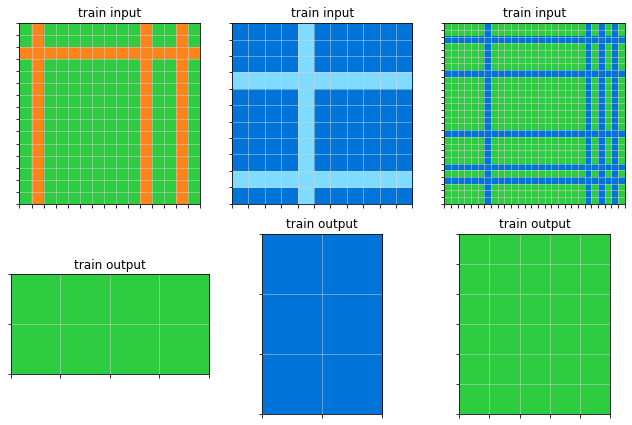

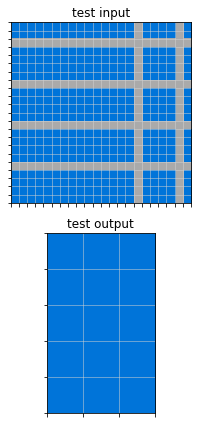

In [ ]:
matrices = get_all_matrix(X_test)

plot_ARC(20, path = "training")

In [ ]:
means = [np.mean(matrix) for matrix in matrices]
fig = ff.create_distplot([means], group_labels=["Means"], colors=["green"])
fig.update_layout(title_text="Distribution of matrix mean values")

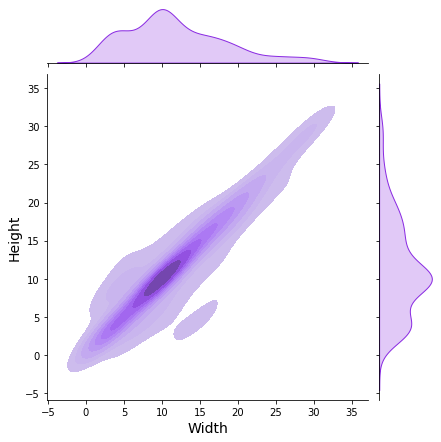

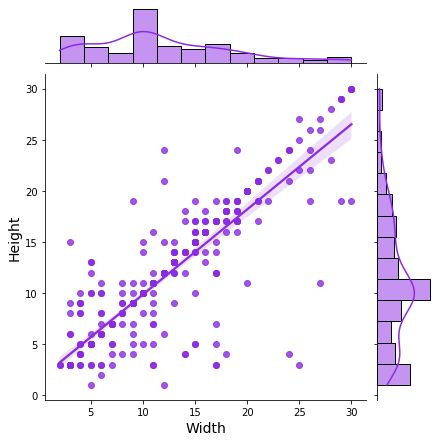

In [ ]:
heights = [np.shape(matrix)[0] for matrix in matrices]
widths = [np.shape(matrix)[1] for matrix in matrices]

plot = sns.jointplot(x=widths, y=heights, kind="kde", fill=True, thresh = 0.09, color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

plot = sns.jointplot(x=widths, y=heights, kind="reg", color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

## **PyTorch Dataset**

Preparing the data for the PyTorch framework, applying pre-processing (e.g., scaling, one-hot encoding, padding) and augmentations (e.g., color_flip, rotation). Can be directly processed into train_loader PyTorch method.


In [7]:
# Load in Dataset (incl. Augmentations, Padding)
class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train", aug=[True, True, True]):
        self.stage = stage

        if self.stage == "train":
            self.X, self.y = preprocess_matrix(X, y, aug)
            self.X = get_final_matrix(self.X, self.stage)
            self.y = get_final_matrix(self.y, self.stage)
        else:
            self.X = get_final_matrix(X, self.stage)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        inp = self.X[idx]
        inp = torch.tensor(inp, dtype=torch.float32)

        if self.stage == "train":
            outp = self.y[idx]
            outp = torch.tensor(outp, dtype=torch.float32)
            return inp, outp
        else:
            return inp

In [ ]:
# Loading Loaders for later Training & Evaluation
batch_size = 64

train_set = ARCDataset(X_train, y_train, stage="train", aug=[True, True, True])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

eval_set = ARCDataset(X_train_e, y_train_e, stage="train", aug=[True, True, True])
eval_loader = DataLoader(eval_set, batch_size=batch_size, shuffle=True)

Augmentation: Random Color Flipping
Augmentation: Random Rotation
Augmentation: Midpoint Mirroring


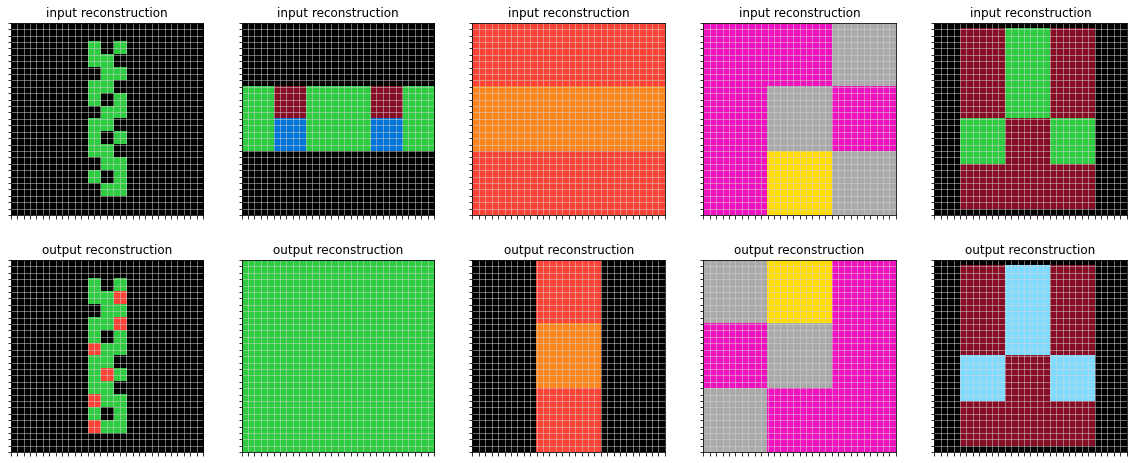

In [ ]:
# Showcase Padding, One-Hot Encoding, Dimensionality, and Augmentation with regards to Colors
fig, axs = plt.subplots(2, 5, figsize=(20,8))
for i in range(5):
    idx = random.randrange(len(train_set.X))
    plot_one(reverse_one_hot_encoder(train_set.X[idx]), axs[0,i], i, 'input')
    plot_one(reverse_one_hot_encoder(train_set.y[idx]), axs[1,i], i, 'output')

## **Variational Autoencoder**
Outlines the VAE architecture (modifiable), including encoder, decoder, and probabilistic sampling of latent representation.

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, img_channels=10, feature_dim=[64, 2, 2], latent_dim=64): # Alternatives 32, 22, 22 / 64, 24, 24
        super(VariationalAutoencoder, self).__init__()

        self.f_dim = feature_dim

        # Initializing the convolutional layers and 2 full-connected layers for the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, 
                      out_channels=128, 
                      kernel_size=4,
                      stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=4,
                      stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, 
                      out_channels=64, 
                      kernel_size=4,
                      stride=2),
            nn.LeakyReLU())
        self.fc_mu = nn.Linear(np.prod(self.f_dim), latent_dim)
        self.fc_var = nn.Linear(np.prod(self.f_dim), latent_dim)

        # Initializing the fully-connected layer and convolutional layers for decoder
        self.dec_inp = nn.Linear(latent_dim, np.prod(self.f_dim))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=128,
                               kernel_size=4,
                               stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=4,
                               stride=2),
            nn.LeakyReLU(),
            # Final Layer
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=img_channels, 
                               kernel_size=4,
                               stride=2),
            nn.Sigmoid())

    def encode(self, x):
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = self.encoder(x)
        x = x.view(-1, np.prod(self.f_dim))
        mu = self.fc_mu(x)
        logVar = self.fc_var(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):
        # Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.dec_inp(z)
        x = x.view(-1, self.f_dim[0], self.f_dim[1], self.f_dim[2])
        x = self.decoder(x)
        return x.squeeze()

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        out = self.decode(z)
        return out, mu, logVar

In [ ]:
# Check convolutional effect on image/task size (for feature_dim adjustment)
convo_eff(w = 30, num = 3, k = 4, p = 0, s = 2)

2.0

## **Training**
Training the layers/weights of the β-VAE to generate representations producing accurate reconstructions of the given inputs. For each epoch the respective loss is printed, calculated through a combination of binary cross entropy and Kullback-Leibler divergence.

In [ ]:
# Define model
vae = VariationalAutoencoder().to(device)

# Training the network for a given number of epochs
def train(model, train_loader, epochs=50):
    optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.2)
    for epoch in range(epochs):
        model.train()
        for batch_idx, (input, output) in enumerate(train_loader):

            # Combine input & output, adding noise, attaching to device
            in_out = torch.cat((input, output), dim=0)
            # in_out_noisy = add_noise(in_out, noise=0.2)
            in_out = in_out.to(device)
            # in_out_noisy = in_out_noisy.to(device)

            # Feeding a batch of images into the network to obtain the output image, mu, and logVar 
            out, mu, logVar = model(in_out)

            # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
            kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
            loss = F.binary_cross_entropy(out, in_out, reduction='sum') + kl_divergence

            # Backpropagation based on the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch {}: Loss {}'.format(epoch+1, loss))
    
    return model

vae_final = train(vae, train_loader, epochs=60)

torch.save(vae_final, '/content/drive/MyDrive/Thesis_LucaThoms/Models/model_64_test.pt')

Epoch 1: Loss 26842.92578125
Epoch 2: Loss 25685.259765625
Epoch 3: Loss 23491.240234375
Epoch 4: Loss 24285.205078125
Epoch 5: Loss 32127.07421875


## **Evaluation**
Evaluating the above training through means of auxillary tools:
1. Random display of input and respective reconstructions
2. Plot demonstrating task reconstruction accuracy (measured by correct pixels)
3. Heatmap illustrating individual pixel accuracy

In [30]:
# Load model for testing
model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/Models/model_64_bce_4k_2s_wd02.pt', map_location=torch.device(device))

# Create lists to store input and output (reconstructions)
X_inp = []
X_out = []

def validate(model, eval_loader):
    # Put model in evaluation mode and start reconstructions based on latent vector
    model.eval()
    with torch.no_grad():
        for batch_idx, (input, output) in enumerate(eval_loader):
            in_out = torch.cat((input, output), dim=0).to(device)
            out, mu, logVar = model(in_out)
            for i in range(len(in_out)):
                X_inp.append(reverse_one_hot_encoder(in_out[i].cpu().numpy()))
                X_out.append(reverse_one_hot_encoder(out[i].cpu().numpy()))
    return X_inp, X_out

X_inp, X_out = validate(model_vae, eval_loader)

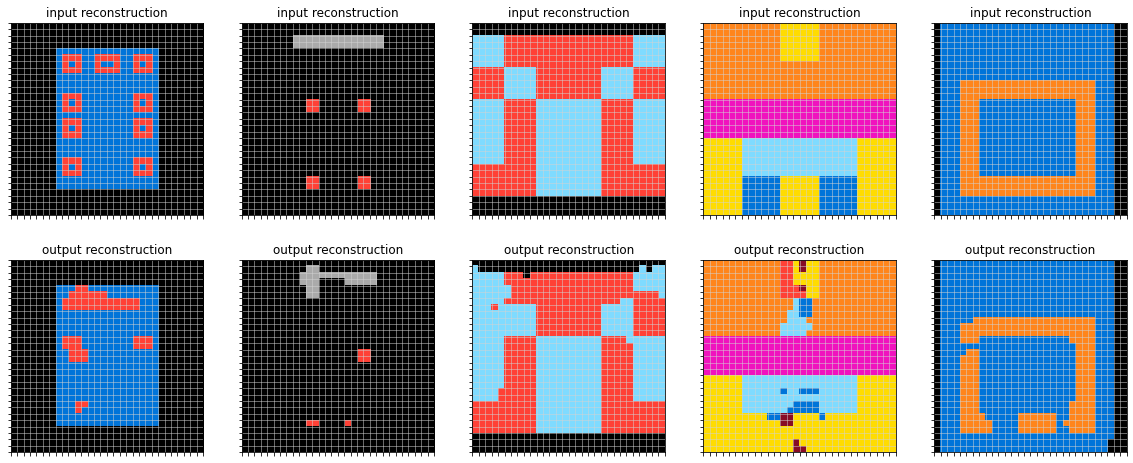

In [ ]:
# Visualize five random tasks and their respective reconstructions (output)
fig, axs = plt.subplots(2, 5, figsize=(20,8))
for i in range(5):
    idx = random.randrange(len(X_inp))
    plot_one(X_inp[idx], axs[0,i], i, 'input')
    plot_one(X_out[idx], axs[1,i], i, 'output')

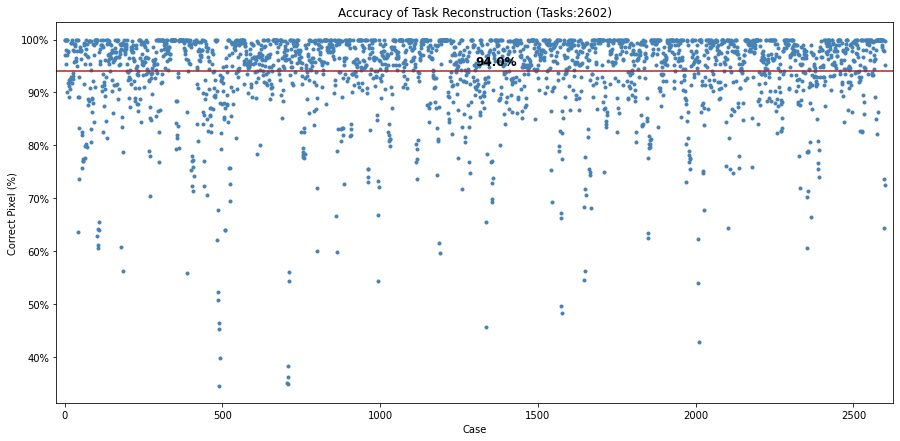

Number of 100% Correct Reconstructions: 448
Number of 90%+ Correct Reconstructions: 2135
Number of 80%+ Correct Reconstructions: 2442
Number of 70%+ Correct Reconstructions: 2545


In [31]:
# Plot differences between input and output matrices (reconstructions)
plot_pix_acc(X_inp, X_out)

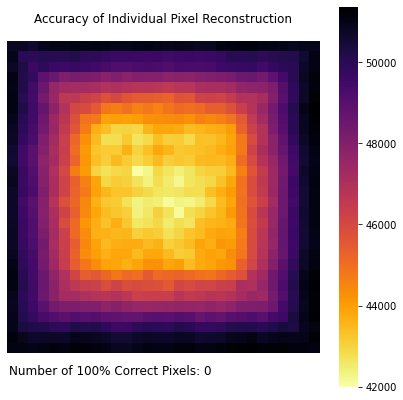

In [ ]:
# Plot heatmap of correct pixel determination by the model (absolute)
plot_pix_heatmap(X_inp, X_out)

## **Visual Analogy Completion**

In [37]:
# Define batch size, create dataloaders and initialize network
batch_size = 1
inp_index = np.insert(np.cumsum([len(i) for i in X_train]), 0, 0)

test_set_few = ARCDataset(X_train, y_train, stage="train", aug=[False, False, False])
test_set_sol = ARCDataset(X_test, y=None, stage="test", aug=[False, False, False])
test_loader_few = DataLoader(test_set_few, batch_size=batch_size)
test_loader_sol = DataLoader(test_set_sol, batch_size=batch_size)

# Load model for testing
model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/Models/model_64_bce_4k_2s_wd02.pt', map_location=torch.device(device))

# Access VAE model latent vector
def visual_analogy(model, test_loader_few, test_loader_sol, inp_index, comp='average'):
    model.eval()
    with torch.no_grad():
        Z_few = []
        Z_few_i = []
        for idx, ((input, output)) in enumerate(test_loader_few):
            
            mu, logVar = model.encode(input.to(device))
            z_inp = model.reparameterize(mu, logVar)

            mu, logVar = model.encode(output.to(device))
            z_out = model.reparameterize(mu, logVar)
            
            z_few = z_out.cpu().numpy().squeeze() - z_inp.cpu().numpy().squeeze()
            Z_few.append(z_few)
            Z_few_i.append(z_inp.cpu().numpy().squeeze())
        
        Z_sol = []
        Z_sol_i = []
        for idx, input in enumerate(test_loader_sol):

            mu, logVar = model.encode(input.to(device))
            z_sol = model.reparameterize(mu, logVar)
            Z_sol.append(z_sol.cpu().numpy().squeeze())
            Z_sol_i.append(input.to(device))

        # Average rule vectors
        Z_avg = []
        for i in range(len(inp_index)-1):
            Z_avg.append(np.mean(Z_few[inp_index[i]:inp_index[i+1]], axis=0))

        # Similarity rule vector
        Z_sim = []
        for i in range(len(inp_index)-1):
            Z_temp = Z_few_i[inp_index[i]:inp_index[i+1]]
            Z_cos = []
            for t in range(len(Z_temp)):
                cosine_sim = np.dot(Z_temp[t], Z_sol[i])/(norm(Z_temp[t])*norm(Z_sol[i]))
                Z_cos.append(cosine_sim)
            Z_cos_a = [abs(num) for num in Z_cos]
            idx = list(range(inp_index[i], inp_index[i+1]))[Z_cos_a.index(max(Z_cos_a))]

            Z_sim.append(Z_few[idx])

        # Check encoding consistency (rule complexity)
        Z_cons = []
        for i in range(len(Z_avg)):
            cosine_sim = np.dot(Z_avg[i], Z_sim[i])/(norm(Z_avg[i])*norm(Z_sim[i]))
            Z_cons.append(cosine_sim)

        # for i in range(len(inp_index)-1):
        #     Z_temp = Z_few_i[inp_index[i]:inp_index[i+1]]
        #     Z_euc = []
        #     for t in range(len(Z_temp)):
        #         euclidean_sim = np.linalg.norm(Z_temp[t] - Z_sol[i])
        #         Z_euc.append(euclidean_sim)
        #     idx = list(range(inp_index[i], inp_index[i+1]))[Z_euc.index(min(Z_euc))]

        #     Z_comp.append(Z_few[idx])

        if comp == 'average':
            Z_comp = Z_avg
        elif comp == 'similarity':
            Z_comp = Z_sim

        Z_sol_r = []
        for i in range(len(Z_comp)):
            z_sol_r = Z_comp[i] + Z_sol[i]
            Z_sol_r.append(model.decode(torch.tensor(z_sol_r, dtype=torch.float32).unsqueeze(0).to(device)))
    
    return Z_sol_i, Z_sol_r, Z_cons

Z_sol_i, Z_sol_r, Z_cons = visual_analogy(model_vae, test_set_few, test_set_sol, inp_index, comp='similarity')

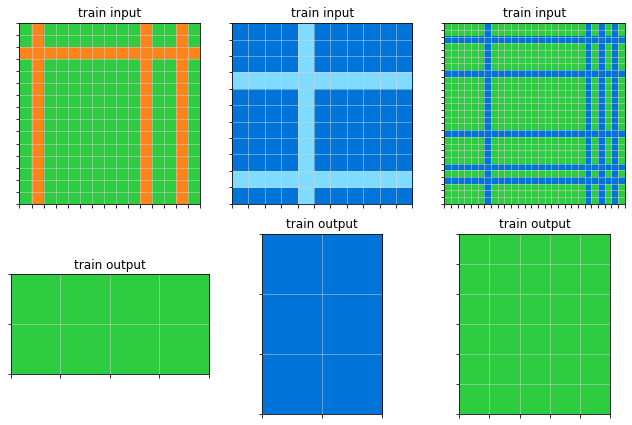

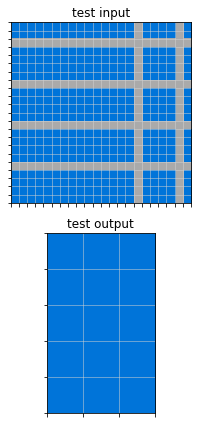

Encoding Consistency 0.64:


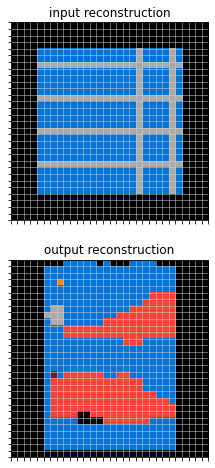

In [52]:
idx = 20

plot_ARC(idx, path='training')
# Visualize five random tasks and their respective reconstructions (output)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
for i in range(1):
    print('Encoding Consistency {0:.{1}f}:'.format(Z_cons[idx], 2))
    plot_one(reverse_one_hot_encoder(Z_sol_i[idx].squeeze().cpu().numpy()), axs[0], i, 'input')
    plot_one(reverse_one_hot_encoder(Z_sol_r[idx].squeeze().cpu().numpy()), axs[1], i, 'output')

## **Predictions**

In [ ]:
## Saving models
torch.save(vae_final, '/content/drive/MyDrive/Thesis_LucaThoms/Models/model_64_bce_4k_2s.pt')
# model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/model.pt', map_location=torch.device(device))

## Saving predictions
# with open('example_pred.pkl', 'wb') as f:
#   pickle.dump(test_predictions, f)

# Loading saved predictions
# with open('/content/drive/MyDrive/Thesis_LucaThoms/example_pred.pkl', 'rb') as f:
#     test_predictions = pickle.load(f)